In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

In [2]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs = load_from_local('../data/1000G/1000G_PCA')
labels = load_from_local('../data/1000G/1000G_labels')
admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

In [3]:
fis_scores = pd.read_csv('../data/1000G/fis_scores.csv')
fis_scores = fis_scores.set_index('sample_id')
fis_scores = fis_scores.loc[labels.index.tolist()]

In [4]:
exp_path = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/1000G'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
inputs_raw, _, samples, snp_names, _ = data_loader.load_data_1000G(os.path.join(exp_path, fname))

In [5]:
inputs_raw.shape # genotype data

(2504, 229986)

In [6]:
# Estimate heterozygosity from raw inputs
heterozygosity = (inputs_raw == 1).sum(1)

In [7]:
# initial 2D phate embedding
phate_operator42_2d = phate.PHATE(random_state=42, 
                                  n_components=2, 
                                  knn=5, 
                                  n_pca=None,
                                  decay=60,
                                  t=5)
phate_operator42_2d.fit(inputs)
phate_emb42_2d = phate_operator42_2d.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.40 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.42 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.12 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.02 seconds.
Calculated landmark operator in 3.69 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.70 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.02 seconds.


<Axes: title={'center': 'PHATE'}, xlabel='PHATE 1', ylabel='PHATE 2'>

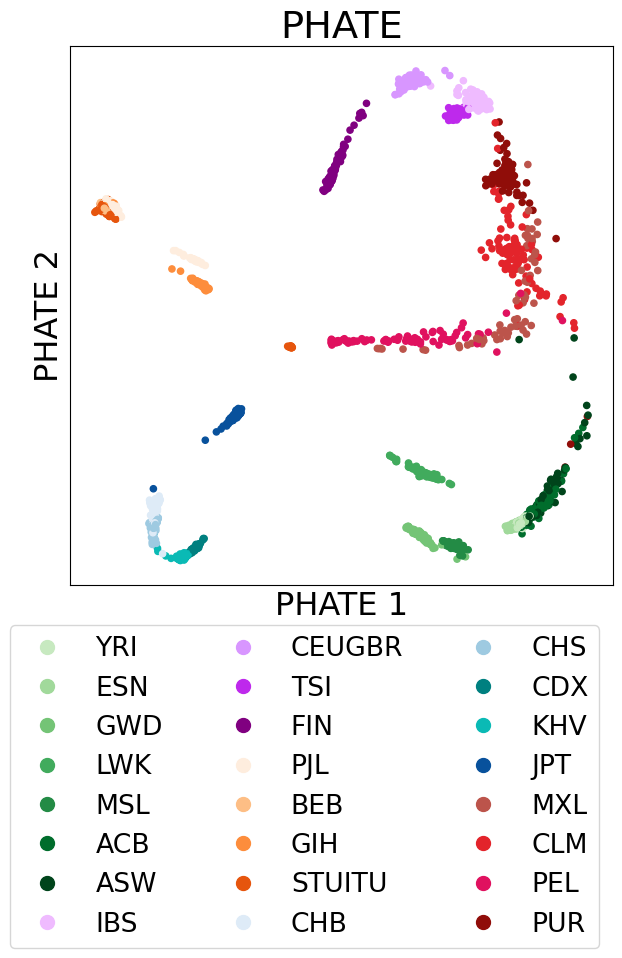

In [8]:
# PHATE
fig, ax = plt.subplots(figsize=(7, 7), gridspec_kw={'wspace': 0.1})

scprep.plot.scatter2d(phate_emb42_2d, s=20, ax=ax,
                      cmap=mappings.pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend_ncol=3, legend_anchor=(1, -0.05),
                      label_prefix="PHATE ",title='PHATE', fontsize=16)

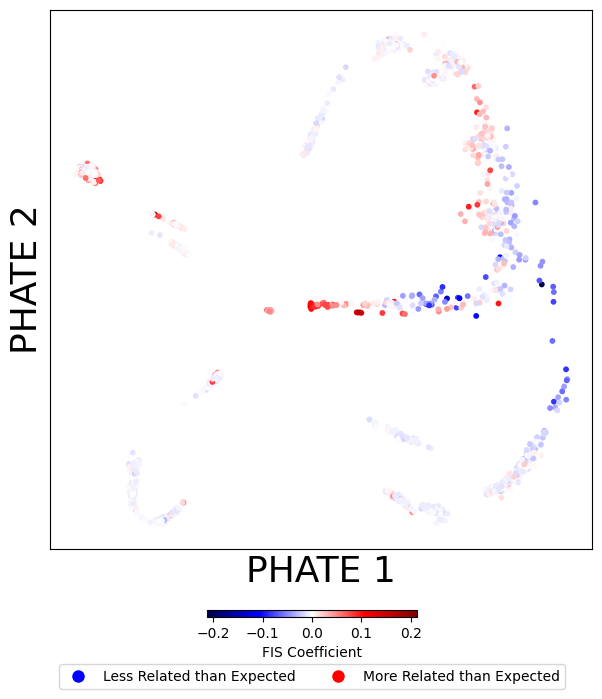

In [9]:
vmin = -np.abs(fis_scores['fis']).max()
vmax = np.abs(fis_scores['fis']).max()

fig, ax = plt.subplots(figsize=(7, 7), gridspec_kw={'wspace': 0.15})

scatter_admix = scprep.plot.scatter2d(phate_emb42_2d, 
                                      s=10, ax=ax,
                                      c=fis_scores['fis'], 
                                      xticks=False, 
                                      yticks=False, 
                                      legend=False,
                                      label_prefix='PHATE ', 
                                      fontsize=18, 
                                      cmap='seismic',
                                      vmin=vmin,  # Set the colormap minimum
                                      vmax=vmax)  # Set the colormap maximum

# Add custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Less Related than Expected'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='More Related than Expected')
]

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.013, 0.3, 0.01])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('FIS Coefficient')

# Add legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()

## Just look at usual heterozygosity

In [10]:
def scale_to_neg1_pos1(x):
    min_x = np.min(x)
    max_x = np.max(x)
    return 2 * ((x - min_x) / (max_x - min_x)) - 1

transformed_score = scale_to_neg1_pos1(heterozygosity)

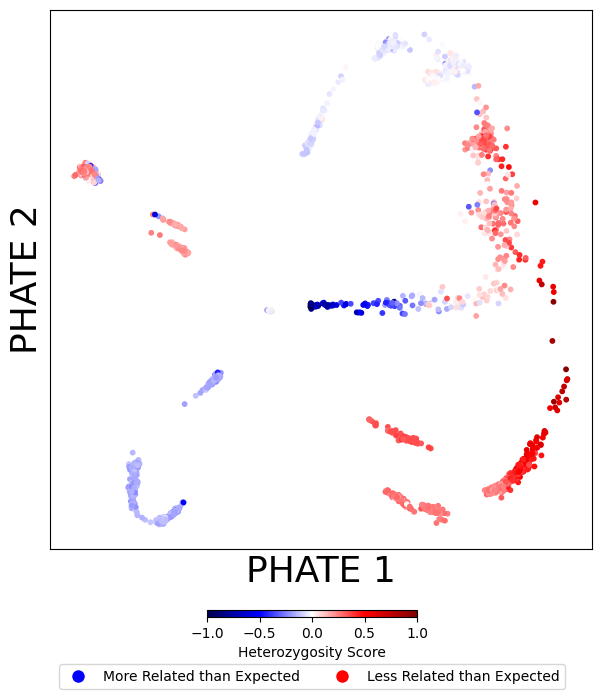

In [11]:
vmin = -np.abs(transformed_score).max()
vmax = np.abs(transformed_score).max()

fig, ax = plt.subplots(figsize=(7, 7), gridspec_kw={'wspace': 0.15})

scatter_admix = scprep.plot.scatter2d(phate_emb42_2d, 
                                      s=10, ax=ax,
                                      c=transformed_score, 
                                      xticks=False, 
                                      yticks=False, 
                                      legend=False,
                                      label_prefix='PHATE ', 
                                      fontsize=18, 
                                      cmap='seismic',
                                      vmin=vmin,  # Set the colormap minimum
                                      vmax=vmax)  # Set the colormap maximum

# Add custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='More Related than Expected'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Less Related than Expected')
]

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.013, 0.3, 0.01])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Heterozygosity Score')

# Add legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()

## This time, 16 points in middle instead of 9

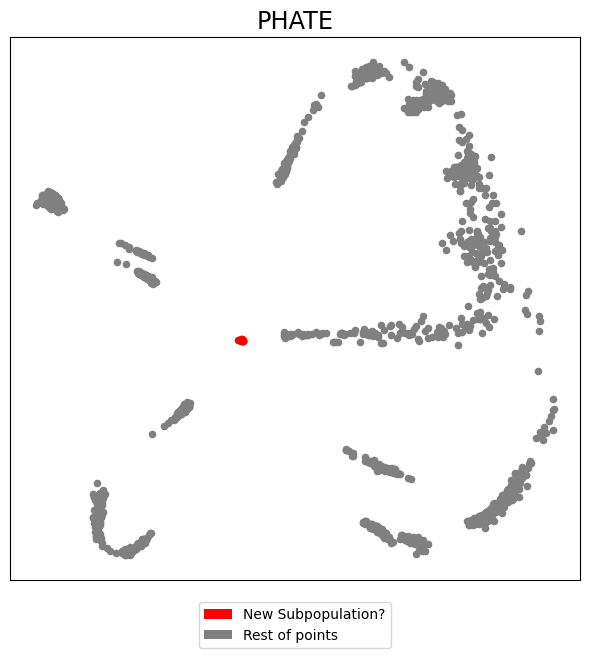

In [12]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(6, 6))

middle_idx = (phate_emb42_2d[:, 0] < -0.001) & (phate_emb42_2d[:, 0] < -0.003) & (np.abs(phate_emb42_2d[:, 1]) < 0.001)

scprep.plot.scatter2d(phate_emb42_2d[~middle_idx], s=20, ax=ax,
                      color='grey', xticks=False, yticks=False, legend=False,
                      title='PHATE', fontsize=10)

scprep.plot.scatter2d(phate_emb42_2d[middle_idx], s=20, ax=ax,
                      color='red', xticks=False, yticks=False, legend=False,
                      title='PHATE', fontsize=10)

legend_elements = [Patch(facecolor='red', label='New Subpopulation?'),
                   Patch(facecolor='grey', label='Rest of points')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()

In [13]:
# Check if these correspond to the same points we found before
ITU_subpopulation = ['HG03718', 'HG03772', 'HG03773', 'HG03785', 'HG04017', 'HG04023', 'HG04026', 'HG04054', 'HG04056']
ITU_subpopulation_idxs = inputs.index.isin(ITU_subpopulation)

# all 9 contained in the 16 in the middle!
labels[middle_idx].index.isin(ITU_subpopulation).sum()/len(ITU_subpopulation)

1.0